In [1]:
import numpy as np
import scipy.io as sio 
import scipy.signal as sig
from matplotlib import pyplot as plt
%matplotlib inline
import random 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, Normalizer
import tensorflow 
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Reshape, Conv1D
from tensorflow.keras.regularizers import l2
import seaborn as sns

In [2]:
dat = sio.loadmat('/Users/soumilhooda/Documents/BCI/Data/BCICIV_4_mat/sub3_comp.mat',struct_as_record=True)
tdat = sio.loadmat('/Users/soumilhooda/Documents/BCI/Data/sub3_testlabels.mat',struct_as_record=True)

train_data = dat['train_data']
test_data = dat['test_data']
train_dg = dat['train_dg']
test_dg = tdat['test_dg']

train_samples,channels = train_data.shape
test_samples = test_data.shape[0]  
channel_train_data = np.transpose(train_data,(1,0))
channel_test_data = np.transpose(test_data,(1,0))
finger_train_data = np.transpose(train_dg,(1,0))
finger_test_data = np.transpose(test_dg,(1,0))

sampling_frequency = 1000

In [3]:
# FIR filter 
def bandPass(signal,fl,fh):
    taps = 505
    band = np.array([fl,fh])
    h = sig.firwin(taps,band,fs=sampling_frequency,pass_zero='bandpass')
    output = np.convolve(signal,h,mode='same')
    return output

# Amplitude modulation : 
def AM(signal,samples):
    cur = 0
    output = []
    for i in range(samples):
        if(i and i % 40 == 0):
            output.append(cur)
            cur = 0
        cur += signal[i]**2
    output.append(cur)
         
    return output

def assign_states(finger_data):
    # State assignment : (0 : rest, 1-5 finger flexed)
    dsamples = len(finger_data[0])
    states = [None]*dsamples
    threshold_1,threshold_2  = 2.0,1.0
    for i in range(dsamples):
        flex,rest = 0,0
        for j in range(5):
            if finger_data[j][i] >= threshold_1:
                states[i] = j + 1
                flex += 1
            elif finger_data[j][i] < threshold_2:
                rest += 1
        if states[i] == None:
            if rest:
                states[i] = 0

    return states

def restrict_zeroes(signal,states):
    # Randomly restrict zeroes in a continuous region
    ends = []
    z_buckets = []
    cur = 0
    for i in range(len(states)):
        if(states[i] == 0):
            cur += 1
        else:
            if(cur == 0):
                continue
            z_buckets.append(cur)
            ends.append(i-1)
            cur = 0

    if(cur):
        z_buckets.append(cur)
        ends.append(len(states)-1)

    keeps = []
    for i in range(len(ends)):
        start = ends[i] - z_buckets[i] + 1
        rl = random.sample(range(start,ends[i]),min(3,z_buckets[i]-1))
        rl = sorted(rl)
        for e in rl:
            keeps.append(e)

    # Fresh Data : 
    new_ch = []
    for i in range(len(signal)):
        curch = []
        idx = 0
        for j in range(len(states)):
            if(states[j]):
                curch.append(signal[i][j])
            else:
                if(idx < len(keeps) and j == keeps[idx]):
                    curch.append(signal[i][j])
                    idx += 1
        new_ch.append(curch)

    new_states = []
    idx = 0
    for i in range(len(states)):
        if(states[i]):
            new_states.append(states[i])
        elif(idx < len(keeps) and i == keeps[idx]):
            new_states.append(states[i])
            idx += 1

    return new_ch,new_states 

In [4]:
# Seperate channel_data into frequency bands : 
train_sub_band = [bandPass(x,1,60) for x in channel_train_data]
train_gamma_band = [bandPass(x,60,100) for x in channel_train_data]
train_fast_gamma_band = [bandPass(x,100,200) for x in channel_train_data]
test_sub_band = [bandPass(x,1,60) for x in channel_test_data]
test_gamma_band = [bandPass(x,60,100) for x in channel_test_data]
test_fast_gamma_band = [bandPass(x,100,200) for x in channel_test_data]

In [5]:
# Perform amplitude modulation on each band :
train_sub_band = [AM(x,train_samples) for x in train_sub_band]
train_gamma_band = [AM(x,train_samples) for x in train_gamma_band]
train_fast_gamma_band = [AM(x,train_samples) for x in train_fast_gamma_band]
train_full_band = [AM(x,train_samples) for x in channel_train_data]
test_sub_band = [AM(x,test_samples) for x in test_sub_band]
test_gamma_band = [AM(x,test_samples) for x in test_gamma_band]
test_fast_gamma_band = [AM(x,test_samples) for x in test_fast_gamma_band]
test_full_band = [AM(x,test_samples) for x in channel_test_data]

In [6]:
# Finger data downsampling : 
finger_train_data_ds = [None]*5
for i in range(5):
    finger_train_data_ds[i] = [finger_train_data[i][j] for j in range(0,train_samples,40)]

finger_test_data_ds = [None]*5
for i in range(5):
    finger_test_data_ds[i] = [finger_test_data[i][j] for j in range(0,test_samples,40)]

In [7]:
finger_train_states = assign_states(finger_train_data_ds)
finger_test_states = assign_states(finger_test_data_ds)

In [8]:
train_sub_rz,finger_train_states_rz = restrict_zeroes(train_sub_band,finger_train_states)
train_gamma_rz,finger_train_states_rz = restrict_zeroes(train_gamma_band,finger_train_states)
train_fast_gamma_rz,finger_train_states_rz = restrict_zeroes(train_fast_gamma_band,finger_train_states)
train_full_rz,finger_train_states_rz = restrict_zeroes(train_full_band,finger_train_states)

test_sub_rz,finger_test_states_rz = restrict_zeroes(test_sub_band,finger_test_states)
test_gamma_rz,finger_test_states_rz = restrict_zeroes(test_gamma_band,finger_test_states)
test_fast_gamma_rz,finger_test_states_rz = restrict_zeroes(test_fast_gamma_band,finger_test_states)
test_full_rz,finger_test_states_rz = restrict_zeroes(test_full_band,finger_test_states)

In [9]:
# Final Numpy arrays with 4 ECoG arrays and 1 Finger array each for train and test : 

# Train : 
tr_s3_sub = np.array(train_sub_rz)
tr_s3_gamma = np.array(train_gamma_rz)
tr_s3_fastgamma = np.array(train_fast_gamma_rz)
tr_s3_all = np.array(train_full_rz)
tr_s3_finger = np.array(finger_train_states_rz)

# Test :
te_s3_sub = np.array(test_sub_rz)
te_s3_gamma = np.array(test_gamma_rz)
te_s3_fastgamma = np.array(test_fast_gamma_rz)
te_s3_all = np.array(test_full_rz)
te_s3_finger = np.array(finger_test_states_rz)

In [10]:
# Finger One-Hot Encoding

tr_s3_finger = tr_s3_finger.reshape(len(tr_s3_finger), 1)
tr_s3_finger = OneHotEncoder(sparse=False).fit_transform(tr_s3_finger)

te_s3_finger = te_s3_finger.reshape(len(te_s3_finger), 1)
te_s3_finger = OneHotEncoder(sparse=False).fit_transform(te_s3_finger)

In [11]:
tr_s3_sub = tr_s3_sub.T
tr_s3_gamma = tr_s3_gamma.T
tr_s3_fastgamma = tr_s3_fastgamma.T
tr_s3_all = tr_s3_all.T

te_s3_sub = te_s3_sub.T
te_s3_gamma = te_s3_gamma.T
te_s3_fastgamma = te_s3_fastgamma.T
te_s3_all = te_s3_all.T

In [12]:
print(tr_s3_gamma.shape)
print(te_s3_gamma.shape)

(5126, 64)
(1892, 64)


In [13]:
# ECoG Normalization

tr_s3_sub = Normalizer().fit(tr_s3_sub).transform(tr_s3_sub)
tr_s3_gamma = Normalizer().fit(tr_s3_gamma).transform(tr_s3_gamma)
tr_s3_fastgamma = Normalizer().fit(tr_s3_fastgamma).transform(tr_s3_fastgamma)
tr_s3_all = Normalizer().fit(tr_s3_all).transform(tr_s3_all)

te_s3_sub = Normalizer().fit(te_s3_sub).transform(te_s3_sub)
te_s3_gamma = Normalizer().fit(te_s3_gamma).transform(te_s3_gamma)
te_s3_fastgamma = Normalizer().fit(te_s3_fastgamma).transform(te_s3_fastgamma)
te_s3_all = Normalizer().fit(te_s3_all).transform(te_s3_all)

In [14]:
# Reshape to 3D Structure for Conv and BiLSTM

tr_s3_sub = tr_s3_sub.reshape(len(tr_s3_sub),1,len(tr_s3_sub[0]))
tr_s3_gamma = tr_s3_gamma.reshape(len(tr_s3_gamma),1,len(tr_s3_gamma[0]))
tr_s3_fastgamma = tr_s3_fastgamma.reshape(len(tr_s3_fastgamma),1,len(tr_s3_fastgamma[0]))
tr_s3_all = tr_s3_all.reshape(len(tr_s3_all),1,len(tr_s3_all[0]))

te_s3_sub = te_s3_sub.reshape(len(te_s3_sub),1,len(te_s3_sub[0]))
te_s3_gamma = te_s3_gamma.reshape(len(te_s3_gamma),1,len(te_s3_gamma[0]))
te_s3_fastgamma = te_s3_fastgamma.reshape(len(te_s3_fastgamma),1,len(te_s3_fastgamma[0]))
te_s3_all = te_s3_all.reshape(len(te_s3_all),1,len(te_s3_all[0]))

In [15]:
print(tr_s3_sub.shape)
print(tr_s3_gamma.shape)
print(tr_s3_fastgamma.shape)
print(tr_s3_all.shape)
print(te_s3_sub.shape)
print(te_s3_gamma.shape)
print(te_s3_fastgamma.shape)
print(te_s3_all.shape)

(5126, 1, 64)
(5126, 1, 64)
(5126, 1, 64)
(5126, 1, 64)
(1892, 1, 64)
(1892, 1, 64)
(1892, 1, 64)
(1892, 1, 64)


In [16]:
np.random.seed(0)

In [17]:
tr_s3_finger_nonhotencoded = np.argmax(tr_s3_finger,axis=1)
te_s3_finger_nonhotencoded = np.argmax(te_s3_finger,axis=1)

Sub-Band data for Subject 3.

In [18]:
# MODEL

model_s3_sub = keras.Sequential()
model_s3_sub.add(Conv1D(64, 1, activation='relu', input_shape=(1,64)))
model_s3_sub.add(Conv1D(48, 1, activation='relu', ))
forward_layer = LSTM(12, activation='relu')
backward_layer = LSTM(12, activation='relu', go_backwards=True)
model_s3_sub.add(Bidirectional(forward_layer, backward_layer=backward_layer))
model_s3_sub.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_s3_sub.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_s3_sub.summary()

history = model_s3_sub.fit(tr_s3_sub, tr_s3_finger, batch_size = 10, epochs=500)

predictions_tr3_sub = model_s3_sub.predict(tr_s3_sub)
predictions_te3_sub = model_s3_sub.predict(te_s3_sub)
predictions_tr3_sub = np.argmax(predictions_tr3_sub, axis = 1)
predictions_te3_sub = np.argmax(predictions_te3_sub, axis = 1)
np.savetxt('predictions_tr3_sub.txt',predictions_tr3_sub)
np.savetxt('predictions_te3_sub.txt',predictions_te3_sub)


print("Train accuracy : ",accuracy_score(tr_s3_finger_nonhotencoded, predictions_tr3_sub))
print("Test accuracy : ",accuracy_score(te_s3_finger_nonhotencoded, predictions_te3_sub))

2022-07-06 02:59:10.316558: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 02:59:10.316988: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 64)             4160      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 48)             3120      
_________________________________________________________________
bidirectional (Bidirectional (None, 24)                5856      
_________________________________________________________________
dense (Dense)                (None, 6)                 150       
Total params: 13,286
Trainable params: 13,286
Non-trainable params: 0
_________________________________________________________________
Train on 5126 samples
Epoch 1/500
5126/5126 [==============================] - 7s 1ms/sample - loss: 1.7718 - mae: 0.2752 - mse: 0.1377
Epoch 2/500
5126/5126 [==============================] - 3s 672us/sample - loss: 1.7226 - mae: 0.2691 - mse: 0.134

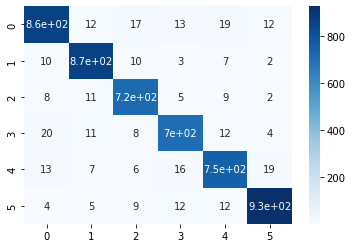

In [19]:
# Train Confusion Matrix
conf_tr_sub = confusion_matrix(tr_s3_finger_nonhotencoded, predictions_tr3_sub)
sns.heatmap(conf_tr_sub, annot=True, cmap='Blues')
plt.show()

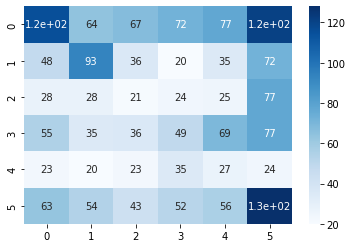

In [20]:
# Test Confusion Matrix
conf_te_sub = confusion_matrix(te_s3_finger_nonhotencoded, predictions_te3_sub)
sns.heatmap(conf_te_sub, annot=True, cmap='Blues')
plt.show()

Gamma-Band for Subject 3.

In [21]:
# MODEL

model_s3_gamma = keras.Sequential()
model_s3_gamma.add(Conv1D(64, 1, activation='relu', input_shape=(1,64)))
model_s3_gamma.add(Conv1D(48, 1, activation='relu', ))
forward_layer = LSTM(12, activation='relu')
backward_layer = LSTM(12, activation='relu', go_backwards=True)
model_s3_gamma.add(Bidirectional(forward_layer, backward_layer=backward_layer))
model_s3_gamma.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_s3_gamma.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_s3_gamma.summary()

history = model_s3_gamma.fit(tr_s3_gamma, tr_s3_finger, batch_size = 10, epochs=500)

predictions_tr3_gamma = model_s3_gamma.predict(tr_s3_gamma)
predictions_te3_gamma = model_s3_gamma.predict(te_s3_gamma)
predictions_tr3_gamma = np.argmax(predictions_tr3_gamma, axis = 1)
predictions_te3_gamma = np.argmax(predictions_te3_gamma, axis = 1)
np.savetxt('predictions_tr3_gamma.txt',predictions_tr3_gamma)
np.savetxt('predictions_te3_gamma.txt',predictions_te3_gamma)


print("Train accuracy : ",accuracy_score(tr_s3_finger_nonhotencoded, predictions_tr3_gamma))
print("Test accuracy : ",accuracy_score(te_s3_finger_nonhotencoded, predictions_te3_gamma))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1, 64)             4160      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 48)             3120      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 24)                5856      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 150       
Total params: 13,286
Trainable params: 13,286
Non-trainable params: 0
_________________________________________________________________
Train on 5126 samples
Epoch 1/500
5126/5126 [==============================] - 7s 1ms/sample - loss: 1.6867 - mae: 0.2649 - mse: 0.1326
Epoch 2/500
5126/5126 [==============================] - 3s 625us/sample - loss: 1.5928 - mae: 0.2530 - mse: 0.1

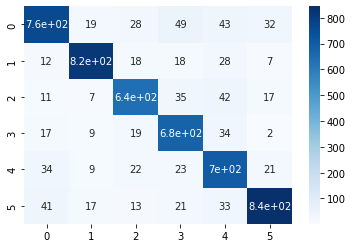

In [22]:
# Train Confusion Matrix
conf_tr_gamma = confusion_matrix(tr_s3_finger_nonhotencoded, predictions_tr3_gamma)
sns.heatmap(conf_tr_gamma, annot=True, cmap='Blues')
plt.show()

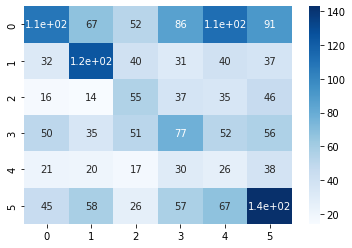

In [23]:
# Test Confusion Matrix
conf_te_gamma = confusion_matrix(te_s3_finger_nonhotencoded, predictions_te3_gamma)
sns.heatmap(conf_te_gamma, annot=True, cmap='Blues')
plt.show()

Fast-Gamma-Band for Subject 3.

In [24]:
# MODEL

model_s3_fastgamma = keras.Sequential()
model_s3_fastgamma.add(Conv1D(64, 1, activation='relu', input_shape=(1,64)))
model_s3_fastgamma.add(Conv1D(48, 1, activation='relu', ))
forward_layer = LSTM(12, activation='relu')
backward_layer = LSTM(12, activation='relu', go_backwards=True)
model_s3_fastgamma.add(Bidirectional(forward_layer, backward_layer=backward_layer))
model_s3_fastgamma.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_s3_fastgamma.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_s3_fastgamma.summary()

history = model_s3_fastgamma.fit(tr_s3_fastgamma, tr_s3_finger, batch_size = 10, epochs=500)

predictions_tr3_fastgamma = model_s3_fastgamma.predict(tr_s3_fastgamma)
predictions_te3_fastgamma = model_s3_fastgamma.predict(te_s3_fastgamma)
predictions_tr3_fastgamma = np.argmax(predictions_tr3_fastgamma, axis = 1)
predictions_te3_fastgamma = np.argmax(predictions_te3_fastgamma, axis = 1)
np.savetxt('predictions_tr3_fastgamma.txt',predictions_tr3_fastgamma)
np.savetxt('predictions_te3_fastgamma.txt',predictions_te3_fastgamma)


print("Train accuracy : ",accuracy_score(tr_s3_finger_nonhotencoded, predictions_tr3_fastgamma))
print("Test accuracy : ",accuracy_score(te_s3_finger_nonhotencoded, predictions_te3_fastgamma))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 1, 64)             4160      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 48)             3120      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 24)                5856      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 150       
Total params: 13,286
Trainable params: 13,286
Non-trainable params: 0
_________________________________________________________________
Train on 5126 samples
Epoch 1/500
5126/5126 [==============================] - 7s 1ms/sample - loss: 1.7887 - mae: 0.2773 - mse: 0.1387
Epoch 2/500
5126/5126 [==============================] - 3s 643us/sample - loss: 1.7853 - mae: 0.2769 - mse: 0.1

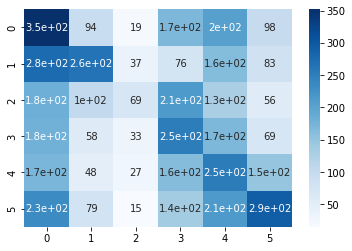

In [25]:
# Train Confusion Matrix
conf_tr_fastgamma = confusion_matrix(tr_s3_finger_nonhotencoded, predictions_tr3_fastgamma)
sns.heatmap(conf_tr_fastgamma, annot=True, cmap='Blues')
plt.show()

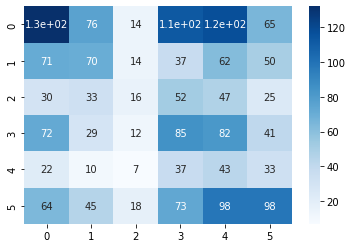

In [26]:
# Test Confusion Matrix
conf_te_fastgamma = confusion_matrix(te_s3_finger_nonhotencoded, predictions_te3_fastgamma)
sns.heatmap(conf_te_fastgamma, annot=True, cmap='Blues')
plt.show()

All-Bands for Subject 3.

In [27]:
# MODEL

model_s3_all = keras.Sequential()
model_s3_all.add(Conv1D(64, 1, activation='relu', input_shape=(1,64)))
model_s3_all.add(Conv1D(48, 1, activation='relu', ))
forward_layer = LSTM(12, activation='relu')
backward_layer = LSTM(12, activation='relu', go_backwards=True)
model_s3_all.add(Bidirectional(forward_layer, backward_layer=backward_layer))
model_s3_all.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_s3_all.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_s3_all.summary()

history = model_s3_all.fit(tr_s3_all, tr_s3_finger, batch_size = 10, epochs=500)

predictions_tr3_all = model_s3_all.predict(tr_s3_all)
predictions_te3_all = model_s3_all.predict(te_s3_all)
predictions_tr3_all = np.argmax(predictions_tr3_all, axis = 1)
predictions_te3_all = np.argmax(predictions_te3_all, axis = 1)
np.savetxt('predictions_tr3_all.txt',predictions_tr3_all)
np.savetxt('predictions_te3_all.txt',predictions_te3_all)


print("Train accuracy : ",accuracy_score(tr_s3_finger_nonhotencoded, predictions_tr3_all))
print("Test accuracy : ",accuracy_score(te_s3_finger_nonhotencoded, predictions_te3_all))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 1, 64)             4160      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1, 48)             3120      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 24)                5856      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 150       
Total params: 13,286
Trainable params: 13,286
Non-trainable params: 0
_________________________________________________________________
Train on 5126 samples
Epoch 1/500
5126/5126 [==============================] - 7s 1ms/sample - loss: 1.7462 - mae: 0.2719 - mse: 0.1361
Epoch 2/500
5126/5126 [==============================] - 3s 641us/sample - loss: 1.6932 - mae: 0.2651 - mse: 0.1

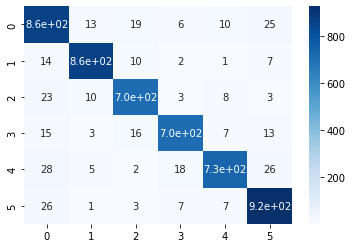

In [28]:
# Train Confusion Matrix
conf_tr_all = confusion_matrix(tr_s3_finger_nonhotencoded, predictions_tr3_all)
sns.heatmap(conf_tr_all, annot=True, cmap='Blues')
plt.show()

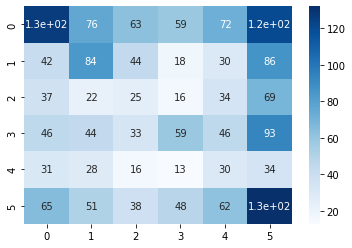

In [29]:
# Test Confusion Matrix
conf_te_all = confusion_matrix(te_s3_finger_nonhotencoded, predictions_te3_all)
sns.heatmap(conf_te_all, annot=True, cmap='Blues')
plt.show()

SUMMARY 

In [30]:
print("Train accuracy for Sub Band: ",accuracy_score(tr_s3_finger_nonhotencoded, predictions_tr3_sub))
print("Test accuracy for Sub Band: ",accuracy_score(te_s3_finger_nonhotencoded, predictions_te3_sub))
print("Train accuracy for Gamma Band: ",accuracy_score(tr_s3_finger_nonhotencoded, predictions_tr3_gamma))
print("Test accuracy for Gamma Band: ",accuracy_score(te_s3_finger_nonhotencoded, predictions_te3_gamma))
print("Train accuracy for Fast Gamma Band: ",accuracy_score(tr_s3_finger_nonhotencoded, predictions_tr3_fastgamma))
print("Test accuracy for Fast Gamma Band: ",accuracy_score(te_s3_finger_nonhotencoded, predictions_te3_fastgamma))
print("Train accuracy for All Band: ",accuracy_score(tr_s3_finger_nonhotencoded, predictions_tr3_all))
print("Test accuracy for All Band: ",accuracy_score(te_s3_finger_nonhotencoded, predictions_te3_all))

Train accuracy for Sub Band:  0.9418650019508389
Test accuracy for Sub Band:  0.22885835095137422
Train accuracy for Gamma Band:  0.8671478735856418
Test accuracy for Gamma Band:  0.2817124735729387
Train accuracy for Fast Gamma Band:  0.28950448692937963
Test accuracy for Fast Gamma Band:  0.2346723044397463
Train accuracy for All Band:  0.9354272337104955
Test accuracy for All Band:  0.24101479915433405
